# <center>Лекція 5. Композиції (ансамблі) алгоритмів</center>

<a class="anchor" id="5"></a>

## Зміст 

- [5.1. Ансамблі алгоритмів](#5.1)
    + [5.1.1. Формалізація ансамблів](#5.1.1)
    + [5.1.2. Бутстреп](#5.1.2)
    + [5.1.3. Беггінг](#5.1.3)
    + [5.1.4. Out-of-bag error](#5.1.4)   
- [5.2. Випадковий ліс](#5.2)
    + [5.2.1. Алгоритм випадкового лісу](#5.2.1)
    + [5.2.2. Порівняння з деревом рішень і беггінгом](#5.2.2)
    + [5.2.3. Параметри випадкового лісу](#5.2.3)
    + [5.2.4. Варіація й декорреляціонний ефект](#5.2.4)
    + [5.2.5. Зміщення](#5.2.5)
    + [5.2.6. Понад випадкові дерева](#5.2.6)
    + [5.2.7. Схожість випадкового лісу з алгоритмом *k*-найближчих сусідів](#5.2.7)
    + [5.2.8. Перетворення ознак в багатовимірний простір](#5.2.8)    
- [5.3. Важливість ознак на прикладі випадкового лісу](#5.3)
    + [5.3.1. Метод випадкового лісу](#5.3.1)
    + [5.3.2. Приклад розрахування важливості ознак](#5.3.2)
- [5.4. Переваги та недоліки використання випадкових лісів в ІАД та МН](#5.4)
- [5.5. Корисні покликання](#5.5)

З попередніх лекцій ви вже дізналися про різні алгоритми класифікації, а також навчилися правильно валідувати й оцінювати якість моделі. Проте що робити, якщо ви вже отримали найкращу модель, але далі не вдається покращити кількісні метрики? У такому випадку потрібно застосувати більш просунуті техніки машинного навчання (МН), які можна об'єднати словом «ансамблі». Ансамбль – це певна сукупність, частини якої утворюють єдине ціле. Зі звичного життя ви, можливо, чули за музичні ансамблі, де об'єднуються кілька музичних інструментів, архітектурні ансамблі з різними будівлями тощо.

Для виконання подальших прикладів спершу підключимо основні бібліотеки:

In [1]:
from __future__ import division, print_function
# відключимо попередження Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

from drawdata import draw_scatter, draw_line, draw_histogram

<a class="anchor" id="5.1"></a>

## <span style="color:blue; font-size:1.2em;">5.1. Ансамблі алгоритмів</span>

[Повернутися до змісту](#5)

<a class="anchor" id="5.1.1"></a>

### <span style="color:blue; font-size:1em;">5.1.1. Формалізація ансамблів</span>

[Повернутися до змісту](#5)

Хорошим прикладом ансамблів вважається теорема Кондорсе «про суд присяжних» (1784) ([парадокс Кондорсе](https://uk.wikipedia.org/wiki/%D0%9F%D0%B0%D1%80%D0%B0%D0%B4%D0%BE%D0%BA%D1%81_%D0%9A%D0%BE%D0%BD%D0%B4%D0%BE%D1%80%D1%81%D0%B5)). Якщо кожен член суду присяжних має незалежну думку, і якщо ймовірність правильного рішення члена суду присяжних більше 0.5, то тоді ймовірність правильного рішення присяжних загалом зростає зі збільшенням кількості членів суду і прямує до одиниці. Якщо ж ймовірність бути правим у кожного з членів журі менше 0.5, то ймовірність прийняття правильного рішення присяжними в цілому монотонно зменшується і прямує до нуля зі збільшенням кількості присяжних.

Формалізуємо цю задачу. Нехай:

- $N$ – кількість присяжних;
- $p$ – ймовірність правильного рішення присяжного;
- $m$ – мінімальна більшість членів суду присяжних, $ m = floor(\frac{N}{2}) + 1 $;
- $C_N^i$ – кількість [комбінацій](https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BC%D0%B1%D1%96%D0%BD%D0%B0%D1%86%D1%96%D1%8F_(%D0%BA%D0%BE%D0%BC%D0%B1%D1%96%D0%BD%D0%B0%D1%82%D0%BE%D1%80%D0%B8%D0%BA%D0%B0)) з $N$ по $i$.

Тоді ймовірність правильного рішення всього суду присяжних:

$$\large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i}, $$

якщо $p > 0.5$, то $\mu > p; $ <br>
якщо $N \rightarrow \infty $, то $\mu \rightarrow 1; $

Розглянемо ще один приклад ансамблів – "Мудрість натовпу", [PDF](https://www.mann-ivanov-ferber.ru/assets/files/bookparts/the_wisdom_of_crowds/mudrost_read.pdf). Френсіс Гальтон в 1906 році відвідав ринок, де проводилася лотерея для мешканців села. Селян зібралося близько 800 чоловік, і вони намагалися вгадати вагу бика, що стояв перед ними. Його вага становила 1198 фунтів. Жоден селянин не вгадав точну вагу бика, але якщо порахувати середнє від їхніх прогнозів, то отримаємо 1197 фунтів. Надалі цю ідею зменшення помилки застосували до методів МН.

<a class="anchor" id="5.1.2"></a>

### <span style="color:blue; font-size:1em;">5.1.2. Бутстреп</span>

[Повернутися до змісту](#5)

Bagging (від Bootstrap aggregation) – це один з перших і найпростіших видів ансамблів. Він був придуманий [Ле́о Бре́йманом](https://en.wikipedia.org/wiki/Leo_Breiman) в 1994 році. Беггінг ґрунтується на статистичному методі бутстреппінга, який дає змогу оцінювати багато статистик складних моделей.

Метод бутстрепа полягає в наступному.

Нехай є вибірка $X$ розміру $N$. Рівномірно візьмемо з вибірки $N$ об'єктів з поверненням. Це означає, що ми будемо $N$ разів вибирати довільний об'єкт вибірки (вважаємо, що кожен об'єкт «дістається» з однаковою ймовірністю $\frac{1}{N}$), водночас кожен раз ми вибираємо з усіх початкових $N$ об'єктів. Можемо уявити мішок, з якого дістають кульки: обрана на певному етапі кулька повертається назад в мішок, і наступний вибір знову робиться з однаковою ймовірністю з того ж числа кульок. Зазначимо, що через повернення кульок у мішок ми можемо отримувати повтори. Позначимо нову вибірку через $X_1$. Повторюючи процедуру $M$ разів, сформуємо $M$ підвибірок $X_1, \dots, X_M$. Тепер ми маємо досить велику кількість вибірок і можемо оцінювати різні статистики початкового розподілу.

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/5_1_bootstrap_eng.png" align="center" width=80% height=80%>

Для прикладу візьмемо вже добре нам відомий набір даних `telecom_churn`. Нагадаємо, що це задача бінарної класифікації відтоку клієнтів. Одним з найважливіших ознак в цьому наборі даних є кількість дзвінків в сервісний центр, які були зроблені клієнтом. Спробуємо візуалізувати дані й поглянемо на розподіл даної ознаки.

In [2]:
telecom_churn_url = 'https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/01_lecture-notes/ida_lecture-01_pandas_data_analysis/telecom_churn.csv'

telecom_data = pd.read_csv(telecom_churn_url)

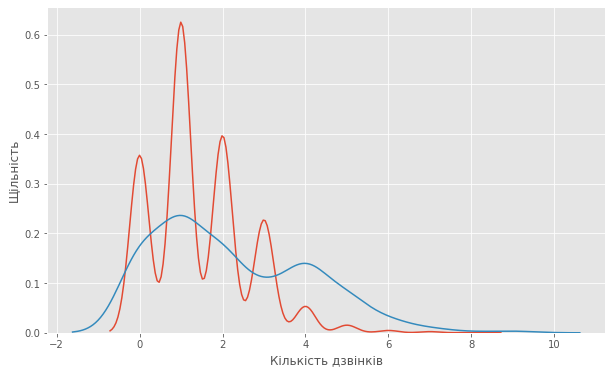

In [3]:
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == False]['Customer service calls'], label = 'Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == True]['Customer service calls'], label = 'Churn')        
fig.set(xlabel='Кількість дзвінків', ylabel='Щільність')
plt.show()

Як ви вже могли помітити, кількість дзвінків в сервісний центр у лояльних клієнтів менше, ніж у колишніх клієнтів. Тепер було б добре оцінити скільки в середньому робить дзвінків кожна з груп. Оскільки даних в нашому наборі мало, то шукати середнє не є раціональним рішенням. Натомість краще застосувати метод бутстрепу, про який ми щойно дізналися. Давайте сформуємо 1000 нових підвибірок з генеральної сукупності й зробимо інтервальну оцінку середнього.

In [4]:
def get_bootstrap_samples(data, n_samples):
    # функція для формування підвибірок за допомогою бутстрепу
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функція для інтервального оцінки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [5]:
# зберігаємо в окремі numpy масиви даних за лояльними та вже колишніми клієнтами
loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
churn_calls= telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

# ставимо seed для відтворюваності результатів
np.random.seed(0)

# формуємо вибірки за допомогою бутстрепу й відразу обраховуємо за кожною з них середнє
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(churn_calls, 1000)]

# виводимо інтервальну оцінку середнього
print("Сервісні дзвінки від лояльних клієнтів (Loyal): середній інтервал",  stat_intervals(loyal_mean_scores, 0.05))
print("Сервісні дзвінки від колишніх клієнтів (Churn): середній інтервал",  stat_intervals(churn_mean_scores, 0.05))

Сервісні дзвінки від лояльних клієнтів (Loyal): середній інтервал [1.4077193  1.49473684]
Сервісні дзвінки від колишніх клієнтів (Churn): середній інтервал [2.0621118  2.39761905]


У підсумку ми отримали, що з 95% ймовірністю середня кількість дзвінків від лояльних клієнтів перебуватиме в проміжку між 1.40 і 1.50; водночас колишні клієнти телефонували в середньому від 2.06 до 2.40 разів. Також варто звернути увагу на те, що інтервал для лояльних клієнтів має довжину лише 0.1, що досить логічно, оскільки вони дзвонять рідко (переважно 0, 1 або 2 рази), а незадоволені клієнти будуть дзвонити значно частіше, але з часом їхнє терпіння закінчиться, і вони поміняють оператора.

<a class="anchor" id="5.1.3"></a>

### <span style="color:blue; font-size:1em;">5.1.3. Беггінг</span>

[Повернутися до змісту](#5)

Маючи загальне уявлення про бустреп, тепер перейдемо безпосередньо до розгляду методу беггінгу.

Нехай є навчальна вибірка $X$. За допомогою бутстрепу сформуємо з неї підвибірки $X_1, \dots, X_M$. Тепер за кожною підвибіркою навчимо свій класифікатор $a_i(x)$. Підсумковий класифікатор буде усереднювати відповіді всіх цих алгоритмів (у випадку класифікації такий підхід відповідає голосуванню):

$$\large a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x).$$

Схему беггінгу подамо рисунком:

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/5_2_bagging.png" align="center" width=80% height=80%>

Розглянемо задачу регресії з базовими алгоритмами $b_1(x), \dots , b_n(x)$. Припустимо, що існує справжня функція відповіді для всіх об'єктів $y(x)$, а також задано розподіл на об'єктах $p(x)$. Тоді ми можемо записати помилку кожної функції регресії, як

$$ \large \varepsilon_i(x) = b_i(x) − y(x),  i = 1, \dots, n$$

і подати математичне очікування середньоквадратичної помилки

$$ \large E_x(b_i(x) − y(x))^{2} = E_x \varepsilon_i (x).$$

Середня помилка побудованих функцій регресії має вигляд

$$ \large E_1 = \frac{1}{n}E_x \sum_{i=1}^n \varepsilon_i^{2}(x). $$

Припустимо, що помилки незміщені й некорельовані: 

$$\large \begin{array}{rcl} E_x\varepsilon_i(x) &=& 0, \\
E_x\varepsilon_i(x)\varepsilon_j(x) &=& 0, i \neq j. \end{array}$$

Побудуємо тепер нову функцію регресії, яка усереднюватиме відповіді побудованих нами функцій:

$$ \large a(x) = \frac{1}{n}\sum_{i=1}^{n}b_i(x). $$

Знайдемо її середньоквадратичну помилку:

$$ \large \begin{array}{rcl}E_n &=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}b_i(x)-y(x)\Big)^2 \\
&=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}\varepsilon_i\Big)^2 \\
&=& \frac{1}{n^2}E_x\Big(\sum_{i=1}^{n}\varepsilon_i^2(x) + \sum_{i \neq j}\varepsilon_i(x)\varepsilon_j(x)\Big) \\
&=& \frac{1}{n}E_1\end{array}. $$

Отже, усереднення відповідей дало змогу зменшити середній квадрат помилки в $n$ разів!

Загальна помилка розкладається так:

$$ \large \begin{array}{rcl} 
\text{Err}\left(\vec{x}\right) &=& \mathbb{E}\left[\left(y – \hat{f}\left(\vec{x}\right)\right)^2\right] \\
&=& \sigma^2 + f^2 + \text{Var}\left(\hat{f}\right) + \mathbb{E}\left[\hat{f}\right]^2 – 2f\mathbb{E}\left[\hat{f}\right] \\
&=& \left(f – \mathbb{E}\left[\hat{f}\right]\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2 \\
&=& \text{Bias}\left(\hat{f}\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2
\end{array}. $$

Беггінг дає змогу знизити дисперсію (variance) класифікатора в процесі навчання, зменшуючи величину, на яку помилка буде відрізнятися, якщо навчати модель за різними наборами даними. Іншими словами, беггінг запобігає перенавчанню. Ефективність беггінга досягається завдяки тому, що базові алгоритми, які пройшли навчання за різними підвибірками, виходять досить різними, і їхні помилки взаємно компенсуються під час голосування, а також за рахунок того, що об'єкти-викиди можуть не потрапляти до деяких навчальних підвибірок.

У бібліотеці `scikit-learn` реалізовано `BaggingRegressor` і `BaggingClassifier`, які дають нагоду використовувати різні алгоритми МН "з коробки".

Розглянемо на практиці як працює беггінг і порівняємо його з деревом рішень, користуючись прикладом з [документації](http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py).

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/5_3_tree-vs-bagging_eng.png" align="center" width=90% height=90%>

Помилка дерева рішень:

$$ \large 0.0255 (Err) = 0.0003 (Bias^2)  + 0.0152 (Var) + 0.0098 (\sigma^2). $$

Помилка беггінга:
$$ \large 0.0196 (Err) = 0.0004 (Bias^2)  + 0.0092 (Var) + 0.0098 (\sigma^2). $$

За графіком і результатами вище видно, що помилка дисперсії набагато менше для беггінгу, як ми і довели теоретично вище.

Беггінг є ефективним на малих вибірках, коли виключення навіть малої частини навчальних об'єктів призводить до побудови істотно різних базових класифікаторів. У разі великих вибірок зазвичай формують підвибірки істотно меншої довжини.

Варто зазначити, що розглянутий нами приклад не надто застосовуваний на практиці, оскільки ми зробили припущення щодо некорельованості помилок, що вкрй рідко трапляється з реальними наборами даних. Якщо це припущення не правильне, то зменшення помилки виявляється не таким значним. Далі ми розглянемо більш складні методи об'єднання алгоритмів в композицію, які дають змогу досягти високих значень метрик в реальних задачах.

<a class="anchor" id="5.1.4"></a>

### <span style="color:blue; font-size:1em;">5.1.4. Out-of-bag error</span>

[Повернутися до змісту](#5)

Забігаючи наперед, відзначимо, що під час використання випадкових лісів немає необхідності використовувати крос-валідацію або окремий тестовий набір, щоб отримати незміщенну оцінку помилки набору тестів. Внутрішню оцінку під час роботи отримують у такий спосіб:

Кожне дерево будується з використанням різних зразків бутстрепа з початкових даних. Приблизно 37% прикладів залишаються поза вибіркою бутстрепа і не використовується для побудови $k$-го дерева.

Наведене вище твердження легко доводиться. Нехай у вибірці є $ell$ об'єктів. На кожному кроці всі об'єкти потрапляють в підвибірку з поверненням з однаковою ймовірністю, тобто окремий об'єкт – з ймовірністю $\frac{1}{\ell}.$ Імовірність того, що об'єкт НЕ потрапить в підвибірку (тобто його не взяли $\ell$ разів):

$$ \large (1 – \frac{1}{\ell})^\ell. $$

За $\ell \rightarrow +\infty$ отримуємо одну з "чудових" меж $\frac{1}{e}$. Тоді ймовірність попадання конкретного об'єкта в підвибірку $\approx  1 – \frac{1}{e} \approx 63\%$.

Тепер подамо вище описане твердження схематично:

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/5_4_oob.png" align="center" width=100% height=100%>

З рисунку бачимо, що наш класифікатор помилився в 4 спостереженнях, які ми не використали для навчання. Це означає, що точність нашого класифікатора становить:

$$\large \frac{11}{15}*100\% = 73.33\%.$$

Виходить, що кожен базовий алгоритм навчається за ~63% початковими об'єктами. Відповідно, на ~37% об'єктах, що залишилися, алгоритм можна відразу перевіряти. Out-of-Bag оцінка – це усереднена оцінка базових алгоритмів на тих ~37% даних, за якими вони не навчалися.

<a class="anchor" id="5.2"></a>

## <span style="color:blue; font-size:1.2em;">5.2. Випадковий ліс</span>

[Повернутися до змісту](#5)

Лео Брейман знайшов застосування бутстрепу не тільки в статистиці, а й в інтелектуальному аналізі даних (ІАД). Він разом з Адель Катлер удосконалив алгоритм випадкового лісу, який був запропонований [Хо](http://resources.krc.karelia.ru/transactions/doc/trudy2013/trudy_2013_1_117-136.pdf), додавши до початкового варіанту побудову некорельованих дерев на основі CART, в поєднанні з методом випадкових підпросторів і беггінгу.

Дерева рішень є хорошим сімейством базових класифікаторів для беггінгу, оскільки вони досить складні і водночас можуть досягати нульової помилки за будь-якої вибірки. Метод випадкових підпросторів дає змогу знизити корельованість між деревами й уникнути перенавчання. Базові алгоритми навчаються за різними підмножинами ознакового опису, які також виділяються випадковим чином.

<a class="anchor" id="5.2.1"></a>

### <span style="color:blue; font-size:1em;">5.2.1. Алгоритм випадкового лісу</span>

[Повернутися до змісту](#5)

Ансамбль моделей, що використовують метод випадкового підпростору, можна побудувати, використовуючи такий алгоритм:

1. Нехай кількість об'єктів для навчання дорівнює $N$, а кількість ознак – $D$.
2. Оберіть $L$ за кількість окремих моделей в ансамблі.
3. Для кожної окремої моделі $l$ виберіть ознаки кількістю $dl (dl <D)$  як кількість ознак для $l$. Зазвичай для всіх моделей використовується тільки одне значення $dl$.
4. Для кожної окремої моделі $l$ створіть навчальну вибірку, вибравши $dl$ ознак поміж $D$ із заміною та виконайте навчання моделі.

Тепер, щоб застосувати модель ансамблю до нового об'єкту, об'єднайте результати окремих $L$ моделей за допомогою мажоритарного голосування або через комбінування [апостеріорних ймовірностей](https://uk.wikipedia.org/wiki/%D0%90%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D1%80%D1%96%D0%BE%D1%80%D0%BD%D0%B0_%D0%B9%D0%BC%D0%BE%D0%B2%D1%96%D1%80%D0%BD%D1%96%D1%81%D1%82%D1%8C#:~:text=%D0%92%20%D0%B1%D0%B0%D1%94%D1%81%D0%BE%D0%B2%D1%96%D0%B9%20%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%86%D1%96%20%D0%B0%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D1%80%D1%96%D0%BE%CC%81%D1%80%D0%BD%D0%B0%20%D0%B9%D0%BC%D0%BE%D0%B2%D1%96%CC%81%D1%80%D0%BD%D1%96%D1%81%D1%82%D1%8C%20(%D0%B0%D0%BD%D0%B3%D0%BB.&text=posterior%20probability%20distribution)%20%E2%80%94%20%D1%86%D0%B5%20%D1%80%D0%BE%D0%B7%D0%BF%D0%BE%D0%B4%D1%96%D0%BB,%D0%BE%D1%82%D1%80%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D0%BC%20%D0%B7%20%D0%B5%D0%BA%D1%81%D0%BF%D0%B5%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D1%82%D1%83%20%D0%B0%D0%B1%D0%BE%20%D1%81%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D1%80%D0%B5%D0%B6%D0%B5%D0%BD%D0%BD%D1%8F.).

Алгоритм побудови випадкового лісу, що складається з $N$ дерев, є таким:
* Для кожного $n = 1, \dots, N$:
     * Сформувати вибірку $X_n$ за допомогою bootstrap.
     * Побудувати дерево рішень $b_n$ за вибіркою $X_n$:
         - за заданим критерієм обирається краща ознака, виконується розбиття в дереві за цією ознакою до закінчення вибірки;
         - дерево будується поки в кожному листі не більше $n_\text{min}$ об'єктів або поки не досягається наперед задана глибина дерева;
         - за кожного розбиття спочатку вибирається $m$ випадкових ознак з $n$ початкових, і далі лише поміж них шукається оптимальний розподіл вибірки.
         
Вирішальний класифікатор:

$$ \large a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x). $$

Іншими словами, для задачі класифікації ми вибираємо рішення голосуванням за більшістю, а в задачі регресії – за середнім.

Рекомендується в задачах класифікації брати $m = \sqrt{n}$, а в задачах регресії – $m = \frac{n}{3}$, де $n$ – кількість ознак. Також рекомендується в задачах класифікації будувати кожне дерево до тих пір, поки в кожному листі не виявиться по одному об'єкту, а в задачах регресії – поки в кожному листі не виявиться по п'ять об'єктів.

Отже, випадковий ліс – це беггінг над деревами рішень, під час навчання яких, для кожного розбиття, ознаки вибираються з деякої випадкової підмножини ознак.

<a class="anchor" id="5.2.2"></a>

### <span style="color:blue; font-size:1em;">5.2.2. Порівняння з деревом рішень і беггінгом</span>

[Повернутися до змісту](#5)

Підключимо пакети `sklearn` для навчання та тестування моделей:

In [39]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

Проведемо порівнння моделей на основі дерева рішень, беггінта з дерев рішень та випадкового лісу для **задачі регресії**.

Сформуємо навчальний та тестові набори даних:

In [40]:
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

Виконаємо навчання регресійної моделі на основі одного дерева рішень:

Text(0.5, 1.0, 'Дерево рішень, MSE = 22.04')

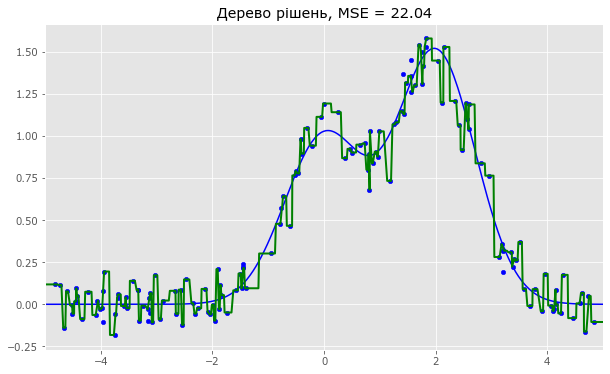

In [41]:
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Дерево рішень, MSE = %.2f" 
          % np.sum((y_test - d_predict) ** 2))

Виконаємо навчання регресійної моделі на основі беггінгу з дерев рішень:

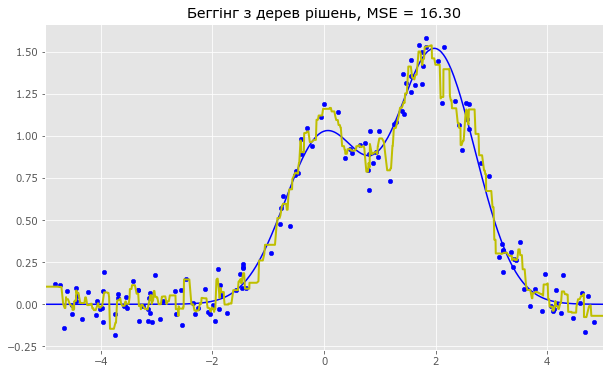

In [42]:
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)
plt.xlim([-5, 5])
plt.title("Беггінг з дерев рішень, MSE = %.2f"
          % np.sum((y_test - bdt_predict) ** 2));

Виконаємо навчання регресійної моделі на основі випадкового лісу:

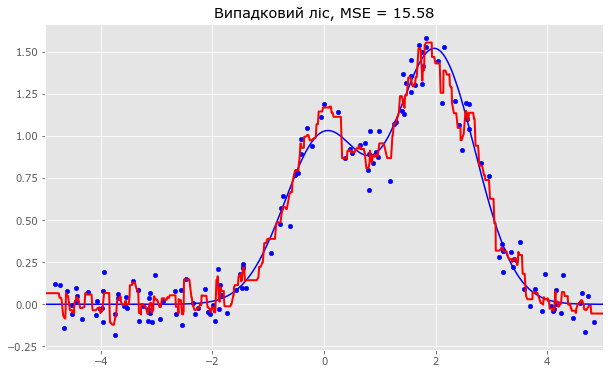

In [43]:
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Випадковий ліс, MSE = %.2f"
          % np.sum((y_test - rf_predict) ** 2));

Як ми бачимо з графіків і значень помилки MSE, випадковий ліс з 10 дерев дає кращий результат, ніж одне дерево або беггінг з 10 дерев рішень. Основна відмінність випадкового лісу й беггінга з деревах рішень полягає в тому, що у випадковому лісі з випадкової кількості дерев вибирається випадкова підмножина ознак, і найкраща ознака для поділу вузла визначається з підвибірки ознак, на відміну від беггінга, де всі функції розглядаються для поділу у вузлі дерева.

Далі проведемо перевірку розглядуваних підходів для **задачі класифікації**.

In [44]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X, y, test_size=0.2)

Виконаємо навчання моделі класифікації на основі дерева рішень:

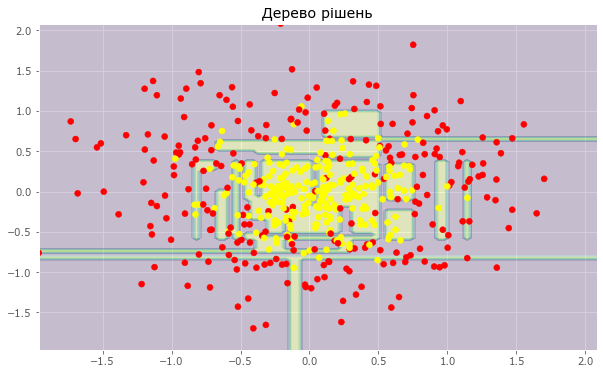

In [45]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Дерево рішень")
plt.show()

Виконаємо навчання моделі класифікації на основі беггінгу з дерева рішень:

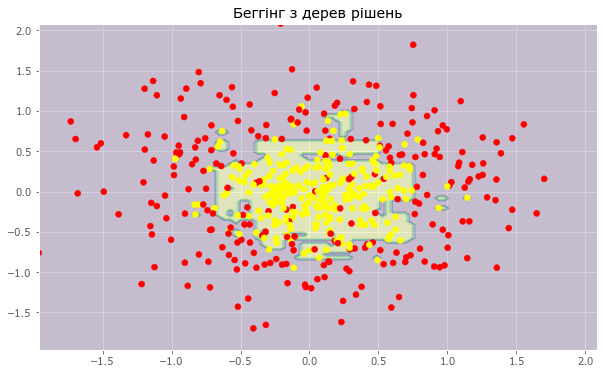

In [46]:
b_dtree = BaggingClassifier(DecisionTreeClassifier(),n_estimators=300, random_state=42)
b_dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Беггінг з дерев рішень")
plt.show()

Виконаємо навчання моделі класифікації на основі випадкового лісу:

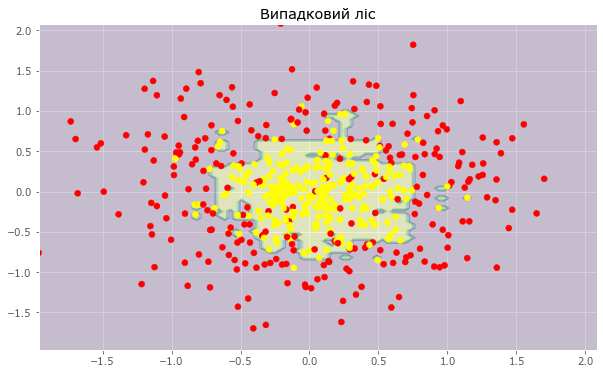

In [47]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Випадковий ліс")
plt.show()

Відповідно до графіків вище бачимо, що розділяюча границя дерева рішень дуже «рвана» і на ній багато гострих кутів, що говорить про перенавчання й слабку узагальнюючу здатність. Водночас як беггінг, так і випадковий ліс демонструють досить згладжену границю, що свідчить про відсутність перенавчання.

Далі спробуємо розібратися з параметрами, підбираючи значення яких, ми зможемо збільшити значення частки правильних відповідей (ЧПВ, accuracy).

<a class="anchor" id="5.2.3"></a>

### <span style="color:blue; font-size:1em;">5.2.3. Параметри випадкового лісу</span>

[Повернутися до змісту](#5)

Метод випадкового лісу реалізований в бібліотеці МН [scikit-learn](http://scikit-learn.org/stable/) двома класами RandomForestClassifier і RandomForestRegressor.

Повний список параметрів випадкового лісу для задачі регресії:

`class sklearn.ensemble.RandomForestRegressor(`
   + n_estimators – кількість дерев в "лісі" (за замовчуванням – 10);
   + criterion – функція, яка вимірює якість розбиття гілки дерева (за замовчуванням – 1"mse", можна вибрати "mae");
   + max_features – кількість ознак, за якими шукається розбиття; можна вказати конкретну кількість або відсоток ознак, або вибрати з доступних значень: "auto" (всі ознаки), "sqrt", "log2"; за замовчуванням – "auto";
   + max_depth – максимальна глибина дерева  (за замовчуванням не обмежена);
   + min_samples_split – мінімальна кількість об'єктів, що необхідна для поділу внутрішнього вузла; можна задати кількістю або відсотком від загальної кількості об'єктів (за замовчуванням – 2);
   + min_samples_leaf – мінімальна кількість об'єктів в листі; можна задати кількісью або відсотком від загальної кількості об'єктів (за замовчуванням – 1);
   + min_weight_fraction_leaf – мінімальна зважена частка від загальної суми ваг (всіх вхідних об'єктів) має бути в листі (за замовчуванням мають однакову вагу);
   + max_leaf_nodes – максимальна кількість листів (за замовчуванням немає обмеження);
   + min_impurity_split – поріг для зупинки нарощування дерева (за замовчуванням – 1е-7);
   + bootstrap – застосовувати бустреп для побудови дерева (за замовчуванням – True);
   + oob_score – чи використовувати out-of-bag об'єкти для оцінки R^2 (за замовчуванням – False);
   + n_jobs – кількість ядер для побудови моделі та передбачень (за замовчуванням – 1, якщо підставити -1, то будуть використовуватися всі ядра);
   + random_state – початкове значення для генерації випадкових чисел (за замовчуванням його немає; якщо хочете відтворювані результати, то потрібно вказати будь-яке число за типом int);
   + verbose – висновок логів за побудови дерев (за замовчуванням – 0);
   + warm_start – використовує вже навчену модель і додає дерева в ансамбль (за замовчуванням – False)

`)`

Для задачі класифікації все майже те ж саме, наведемо лише ті параметри, за якими RandomForestClassifier відрізняється від RandomForestRegressor:

`class sklearn.ensemble.RandomForestClassifier(`
   + criterion – оскільки тут маємо модель класифікації, то за замовчуванням обрано критерій "gini" (можна вибрати "entropy");
   + class_weight – вага кожного класу (за замовчуванням всі ваги дорівнюють 1, але можна передати словник з вагами, або явно вказати "balanced", тоді ваги класів будуть рівні їхнім початковим частинам у генеральній сукупності; також можна вказати "balanced_subsample", тоді ваги за кожною підвибіркою будуть змінюватися в залежності від розподілу класів за цією підвибіркою
    
`)`

Далі розглянемо кілька параметрів, на які в першу чергу варто звернути увагу під час побудови моделі:

- `n_estimators` – кількість дерев в "лісі";
- `criterion` – критерій для розбиття вибірки у вершині;
- `max_features` – кількість ознак, за якими відбувається пошук розбиття;
- `min_samples_leaf` – мінімальна кількість об'єктів в листі;
- `max_depth` – максимальна глибина дерева.

Розглянемо застосування випадкового лісу до реальної задачі.

Використаємо приклад із задачею виявлення шахрайства (з англ. fraud detection). Це задача класифікації, тому будемо використовувати метрику accuracy для оцінювання ЧПВ. Для початку побудуємо найпростіший класифікатор, що матиме роль базової моделі (з англ. baseline). Візьмемо тільки числові ознаки для спрощення.

In [48]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

# Завантажуємо дані
df = pd.read_csv(telecom_churn_url)

# Вибираємо спочатку тільки колонки з числовим типом даних
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)
        
# Поділяємо на ознаки й об'єкти
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

# Ініціалізуємо стратифіковане розбиття нашого набору даних для тестування
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ініціалізуємо наш класифікатор з параметрами за замовчуванням
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# Виконуємо навчання моделі за навчальним набором даних
results = cross_val_score(rfc, X, y, cv=skf)

# Оцінюємо ЧПВ за тестовим набором даних
print("Cross validation accuracy score: {:.2f}%".format(results.mean()*100))

Cross validation accuracy score: 92.50%


Отримали ЧПВ 92.50%. Тепер спробуємо покращити цей результат і подивимося, як поводяться криві навчання у випадку зміни основних параметрів.

Почнемо з кількості дерев:

In [49]:
# Ініціалізуємо тестування
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Створюємо списки для збереження ЧПВ за навчальним та тестовим набороми даних
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

# Проводимо навчання за навчальним набором даних
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 100 trees


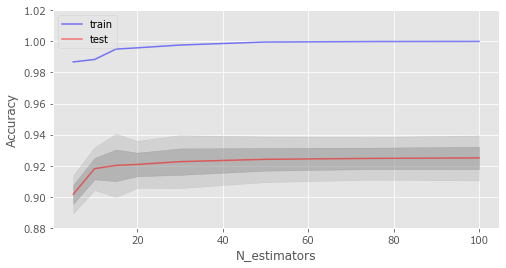

In [50]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

З графіку вище бачимо, що за досягнення певної кількості дерев наша accuracy за тестовим набором даних виходить на асимптоту, і тому ви можете самостійно обрати, яка кількість дерев є оптимальною для вашої задачі.

Далі спробуємо додати параметри регуляризації в модель.

Почнемо з параметра максимальної глибини – `max_depth`. (Зафіксуємо кількість дерев 100)

In [51]:
# Створюємо списки для збереження оцінки ЧПВ за навчальним та тестовим набороми даних
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Проводимо навчання за навчальним набором даних
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.44% with 24 max_depth


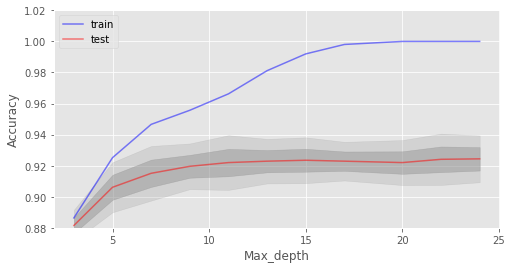

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

Параметр `max_depth` добре справляється з регуляризацією моделі, і модель вже не так сильно перенавчається. ЧПВ нашої моделі трохи зросла.

Ще важливий параметр `min_samples_leaf`, він також виконує функцію регуляризатора.

In [52]:
# Створюємо списки для збереження оцінки ЧПВ за навчальним та тестовим набороми даних
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Виконуємо навчання за навчальним набором даних
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 1 min_samples_leaf


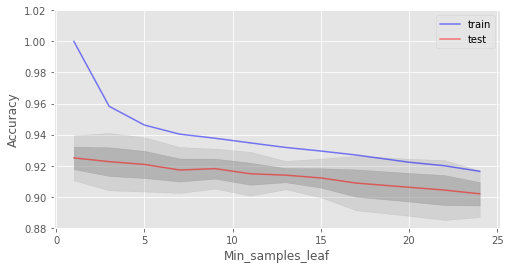

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

Тут ми не виграємо в ЧПВ за тестуванням, але зате можемо сильно зменшити перенавчання до 2% при збереженні ЧПВ близько 92%.

Розглянемо такий параметр як `max_features`. Для задач класифікації за замовчуванням використовується $\sqrt{n}$, де $n$ – кількість ознак. Давайте перевіримо, чи оптимально в нашому випадку використовувати 4 ознаки.

In [22]:
# Створюємо списки для збереження оцінки ЧПВ за навчальним та тестовим набороми даних
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Виконуємо навчання за навчальним набором даних
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 4 max_features


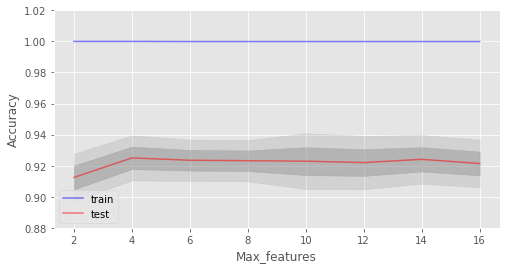

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

У нашому випадку оптимальна кількість ознак – 4, саме з таким значенням досягається найкращий результат.

Ми розглянули, як поводяться криві навчання в залежності від зміни основних параметрів. Давайте тепер за допомогою `GridSearchCV` знайдемо оптимальні параметри для нашого прикладу.

In [24]:
# Проведемо ініціалізацію параметрів, за якими хочемо зробити повний перебір
parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [4, 7, 10, 13],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [25]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(max_depth=20, max_features=10, min_samples_leaf=3,
                        n_jobs=-1, oob_score=True, random_state=42),
 0.925596661128895)

Краща ЧПВ, який ми змогли досягти за допомогою перебору параметрів – 92.56% за `'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3`.

<a class="anchor" id="5.2.4"></a>

### <span style="color:blue; font-size:1em;">5.2.4. Варіація й декореляційний ефект</span>

[Повернутися до змісту](#5)

Подамо варіацію для випадкового лісу як

$$\large Varf(x) = \rho(x)\sigma^2(x) $$

де $\rho(x)$ – кореляція вибірки між будь-якими двома деревами, що використовуються за усереднення:

$$ \large \rho(x) = corr[T(x;\Theta_1(Z)),T(x_2,\Theta_2(Z))],$$

де $\Theta_1(Z) $ та $\Theta_2(Z) $ – випадково обрана пара дерев на випадково обраних об'єктах вибірки $Z$;

$\sigma^2(x)$ – це вибіркова дисперсія будь-якого довільно обраного дерева:

$$ \large \sigma^2(x) = VarT(x;\Theta(X))$$

Легко сплутати $\rho(x)$ з середньою кореляцією між навченими деревами в даному випадковому лісі, розглядаючи дерева як $N$-вектори і обчислюючи середню парну кореляцію між ними. Це не той випадок. Ця умовна кореляція не має прямого відношення до процесу усереднення, а залежність від $x$ в $\rho(x)$ попереджає нас про цю відмінність. Краще сказати, що $\rho(x)$ є теоретичною кореляцією між парою випадкових дерев, що оцінені в об'єкті $x$, яка була викликана багаторазовим розбиттям навчальної вибірки з генеральної сукупності $Z$, і після цього обрана дана пара випадкових дерев. На статистичному жаргоні це кореляція, що викликана вибірковим розподілом $Z$ і $\Theta$.

За фактом, умовна коваріація пари дерев дорівнює 0, тому що бустреп і відбір ознак – незалежні і однаково розподілені.

Якщо розглянути дисперсію за одним деревом, то вона практично не змінюється від змінних для поділу ($m$), а ось для ансамблю це грає велику роль, і дисперсія для дерева набагато вища, ніж для ансамблю. У книзі *The Elements of Statistical Learning (Trevor Hastie, Robert Tibshirani і Jerome Friedman)*, [PDF](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) є відмінний приклад, який це демонструє.

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/5_5_variance_rf.png" align="center" width=100% height=100%>

<a class="anchor" id="5.2.5"></a>

### <span style="color:blue; font-size:1em;">5.2.5. Зміщення</span>

[Повернутися до змісту](#5)

Як і для беггінгу, зміщення у випадковому лісі таке ж, як і зміщення в окремо взятому дереві $T(x,\Theta(Z))$:

$$ \large \begin{array}{rcl} Bias &=& \mu(x) – E_Zf_{rf}(x) \\
&=& \mu(x) – E_ZE_{\Theta | Z}T(x,\Theta(Z))\end{array} $$

Це також зазвичай більше (в абсолютних величинах), ніж зміщення «неусеченного» (unprunned) дерева, оскільки рандомізація та скорочення простору вибірки накладають обмеження. Отже, покращення в прогнозуванні, що отримані за допомогою беггінга або випадкових лісів, є виключно результатом зменшення дисперсії.

<a class="anchor" id="5.2.6"></a>

### <span style="color:blue; font-size:1em;">5.2.6. Понад випадкові дерева</span>

[Повернутися до змісту](#5)

У понад випадкових деревах ([Extremely Randomized Trees](https://link.springer.com/article/10.1007/s10994-006-6226-1)) більше випадковості в тому, як обчислюються поділи у вузлах. Як і в випадкових лісах, використовується випадкова підмножина можливих ознак, але замість пошуку оптимальних порогів, порогові значення довільно вибираються для кожної можливої ознаки, і найкращий з цих випадково сформованих порогів вибирається як краще правило для поділу вузла. Такий підхід зазвичай дає змогу трохи зменшити дисперсію моделі за рахунок трохи більшого збільшення зсуву.

У бібліотеці scikit-learn є реалізація [ExtraTreesClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) и [ExtraTreesRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor). Даний метод варто використовувати, коли ваша модель сильно перенавчається на випадковому лісі або градієнтному бустингу.

<a class="anchor" id="5.2.7"></a>

### <span style="color:blue; font-size:1em;">5.2.7. Схожість випадкового лісу з алгоритмом *k*-найближчих сусідів</span>

[Повернутися до змісту](#5)

Метод випадкового лісу схожий з методом найближчих сусідів. Випадкові ліси здійснюють передбачення для об'єктів на основі міток схожих об'єктів з навчання. Схожість об'єктів водночас тим вища, чим частіше ці об'єкти перебувають в одному і тому ж листі дерева. Покажемо це формально.

Розглянемо задачу регресії з квадратичною функцією втрат. Нехай $T_n(x)$ – номер листа $n$-го дерева з випадкового лісу, в який потрапляє об'єкт $x$. Відповідь об'єкта $x$ дорівнює середньому поміж відповідей за всіма об'єктами навчальної вибірки, які потрапили в цей лист $T_n(x)$. Це можна записати так

$$\large b_n(x) = \sum_{i=1}^{l}w_n(x,x_i)y_i,$$ 

де $$ \large w_n(x, x_i) = \frac{[T_n(x) = T_n(x_i)]}{\sum_{j=1}^{l}[T_n(x) = T_n(x_j)]}.$$

Тоді відповідь композиції дорівнює

$$ \large \begin{array}{rcl} a_n(x) &=& \frac{1}{N}\sum_{n=1}^{N}\sum_{i=1}^{l}w_n(x,x_i)y_i \\
&=& \sum_{i=1}^{l}\Big(\frac{1}{N}\sum_{j=1}^{N}w_n(x,x_j)\Big)y_i \end{array}.$$

Бачимо, що результат випадкового лісу є сумою результатів всіх об'єктів навчання з деякими вагами. Зазначимо, що номер листа $T_n(x)$, в який потрапив об'єкт, є цінною ознакою. Досить непогано працює підхід, в якому за вибіркою навчається композиція з невеликої кількості дерев за допомогою випадкового лісу або градієнтного бустингу, а потім до неї додаються категоріальні ознаки $T_1(x), \dots, T_n(x)$. Нові ознаки є результатом нелінійного розбиття простору й несуть в собі інформацію щодо подібності об'єктів.


У книзі *The Elements of Statistical Learning* ([PDF](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)) є хороший наочний приклад подібності випадкового лісу й *k*-найближчих сусідів.

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/5_6_knn_vs_rf.png" align="center" width=1000% height=100%>

<a class="anchor" id="5.2.8"></a>

### <span style="color:blue; font-size:1em;">5.2.8. Перетворення ознак в багатовимірний простір</span>

[Повернутися до змісту](#5)

Всі звикли використовувати випадковий ліс для задач навчання з учителем, але також є можливість проводити навчання і без учителя. За допомогою методу [RandomTreesEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html#sklearn.ensemble.RandomTreesEmbedding) ми можемо зробити трансформацію нашого набору даних в багатовимірне розріджене його уявлення. Суть цього методу в тому, що будуються абсолютно випадкові дерева, й індекс листа, в якому опинилося спостереження, вважається новою ознакою. Якщо в перший лист потрапив об'єкт, то йому призначається індекс 1, а якщо не потрапив, то – 0. Маємо так зване бінарне кодування.

Можемо контролювати кількість змінних і також ступінь розрідження нового уявлення набору даних збільшуючи або зменшуючи кількість дерев і їхні глибини. Оскільки сусідні точки даних, швидше за все, лежать в одному і тому ж листі дерева, перетворення виконує неявну, непараметричну оцінку щільності.

<a class="anchor" id="5.3"></a>

## <span style="color:blue; font-size:1.2em;">5.3. Важливість ознак на прикладі випадкового лісу</span>

[Повернутися до змісту](#5)

Під час розв'язання реальних задач часто виникає необхідність зрозуміти свій алгоритм, чому він дає певну відповідь саме так, а не інакше. Або якщо не вдається зрозуміти алгоритм повністю, то зазвичай потрібно розуміти які змінні алгоритму мають найбільш суттєвий вплив на кінцевий результат. З випадкового лісу можна досить просто отримати таку інформацію.

<a class="anchor" id="5.3.1"></a>

### <span style="color:blue; font-size:1em;">5.3.1. Метод випадкового лісу</span>

[Повернутися до змісту](#5)

За рисунком нижче інтуїтивно зрозуміло, що важливість ознаки «Вік» у задачі кредитного скорингу вище, ніж важливість ознаки «Дохід». Формалізується це за допомогою поняття приросту інформації.

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/5_7_credit_scoring_toy_tree_english.png" align="center" width=60% height=60%>

Якщо побудувати багато дерев рішень (випадковий ліс), то чим вищою в середньому є ознака в дереві рішень, тим важливішою вона є в даній задачі класифікації/регресії. У разі кожного розбиття в кожному дереві покращення критерію поділу (в нашому випадку коефіцієнт Джині) – це показник важливості, що пов'язаний зі змінною поділу, і накопичується він за усіма деревами лісу окремо для кожної змінної.

Давайте трохи заглибимося в деталі. Середнє зниження точності, що викликається змінною, визначається під час фази обчислення out-of-bag помилки. Чим більше зменшується точність передбачень через виключення (або перестановку) однієї змінної, тим важливішою є ця змінна, і тому змінні з більшим середнім зменшенням точності важливіші для класифікації даних. Середнє зменшення коефіцієнта Джині (або помилки MSE в задачах регресії) є мірою того, як кожна змінна сприяє однорідності вузлів і листя в кінцевій моделі випадкового лісу. Кожен раз, коли окрема змінна використовується для розбиття вузла, коефіцієнт Джині для дочірніх вузлів розраховується і порівнюється з коефіцієнтом початкового вузла. Коефіцієнт Джині є мірою однорідності від 0 (однорідної) до 1 (гетерогенної). Зміни в значенні критерію поділу підсумовуються для кожної змінної і нормуються в кінці обчислення. Змінні, які призводять до вузлів з більш високою чистотою, мають більш високе зниження коефіцієнта Джині.

Далі подамо вказані вище слова у вигляді формул:

$$ \large VI^{T} = \frac{\sum_{i \in \mathfrak{B}^T}I \Big(y_i=\hat{y}_i^{T}\Big)}{\Big |\mathfrak{B}^T\Big |} – \frac{\sum_{i \in \mathfrak{B}^T}I \Big(y_i=\hat{y}_{i,\pi_j}^{T}\Big)}{\Big |\mathfrak{B}^T\Big |}, $$

де
$ \hat{y}_i^{(T)} = f^{T}(x_i)  $ – передбачення класу перед перестановкою/видаленням ознаки;

$ \hat{y}_{i,\pi_j}^{(T)} = f^{T}(x_{i,\pi_j}) $ – передбачення класу після перестановки/видалення ознаки;

$  x_{i,\pi_j} = (x_{i,1}, \dots , x_{i,j-1}, \quad x_{\pi_j(i),j}, \quad x_{i,j+1}, \dots , x_{i,p}).$

Помітно, що $ VI^{(T)}(x_j) = 0 $, якщо $ X_j $  не перебуває у дереві $ T $.

Розрахунок важливості ознак в ансамблі:

- ненормовані:

$$ \large VI(x_j) = \frac{\sum_{T=1}^{N}VI^{T}(x_j)}{N}; $$

- нормовані:
$$ \large z_j = \frac{VI(x_j)}{\frac{\hat{\sigma}}{\sqrt{N}}}. $$

<a class="anchor" id="5.3.2"></a>

### <span style="color:blue; font-size:1em;">5.3.2. Приклад розрахування важливості ознак</span>

[Повернутися до змісту](#5)

Розглянемо результати анкетування відвідувачів хостелів з сайтів Booking.com і TripAdvisor.com. Тут ознаки – середні оцінки за різними чинниками (перераховані нижче) – персонал, стан кімнат тощо. Цільова ознака – рейтинг хостелу на сайті.

In [26]:
# Оголосимо україномовні заголовки
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

In [27]:
hostel_factors_url = 'https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/01_lecture-notes/ida_lecture-05_compositions/hostel_factors.csv'

hostel_data = pd.read_csv(hostel_factors_url)

In [28]:
features = {"f1":u"Персонал",
"f2":u"Бронювання хостела",
"f3":u"Заїзд в хостел і виїзд з хостела",
"f4":u"Стан кімнати",
"f5":u"Стан спільної кухні",
"f6":u"Стан спільного простору",
"f7":u"Додаткові послуги",
"f8":u"Загальні умови та зручності",
"f9":u"Ціна/якість",
"f10":u"Спільне створення цінності"}

In [29]:
# Створюємо модель випадкового лісу для задачі регресії
forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

# Зображаємо важливість ознак випадкового лісу
num_to_plot = 10
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

Feature ranking:
1. Персонал 0.183150 
2. Ціна/якість 0.147704 
3. Стан спільного простору 0.128188 
4. Додаткові послуги 0.116819 
5. Спільне створення цінності 0.105748 
6. Загальні умови та зручності 0.088730 
7. Стан спільної кухні 0.074776 
8. Заїзд в хостел і виїзд з хостела 0.061881 
9. Бронювання хостела 0.053899 
10. Стан кімнати 0.039105 


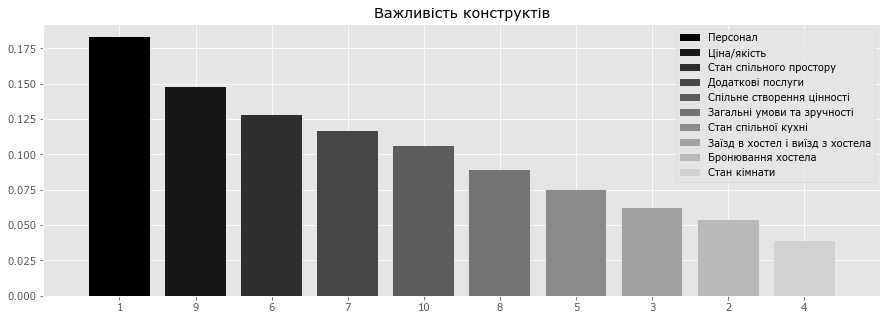

In [30]:
# Виводимо рейтинг ознак
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важливість конструктів")

bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
            for i in range(num_to_plot)]),
               align="center")

ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

На графіку вище бачимо, що люди найбільше звертають увагу на персонал і співвідношення ціна/якість, та на основі враження від цих ознак пишуть свої відгуки. Водночас різниця між цими значущими та менш впливовими ознаками не велика, і тому відкидання якоїсь ознаки призведе до зменшення точності нашої моделі. Втім навіть на основі нашого аналізу ми можемо дати рекомендації готелям в першу чергу краще готувати персонал і/або покращити якість номерів до заявленої ціни.

<a class="anchor" id="5.4"></a>

## <span style="color:blue; font-size:1.2em;">5.4. Переваги та недоліки використання випадкових лісів в ІАД та МН</span>

[Повернутися до змісту](#5)

**Переваги**:
 
 - має високу точність передбачення (accuracy, частка правильних відповідей); на більшості завдань буде краще лінійних алгоритмів; значення ЧПВ відповідає значенню бустинга;
 - практично не чутливий до викидів у даних через випадкове розбиття;
 - нечутливий до масштабування (і взагалі до будь-яких монотонних перетворень) значень ознак; це пов’язане з вибором випадкових підпросторів;
 - не потребує ретельного налаштування гіперпараметрів, добре працює «з коробки»; за допомогою «тюнінгу» гіперпараметрів можна досягти приросту від 0.5 до 3 % ЧПВ залежно від задачі й даних;
 - може ефективно обробляти дані з великою кількістю ознак і класів;
 - однаково добре обробляє як неперервні, так і дискретні ознаки;
 - рідко перенавчається, на практиці додавання дерев майже завжди тільки покращує композицію; проте за валідацією, після досягнення певної кількості дерев, крива навчання виходить на асимптоту;
 - для випадкового лісу є методи оцінювання значущості окремих ознак у моделі;
 - добре працює з пропущеними даними; зберігає хорошу точність, якщо більша частина даних пропущені;
 - передбачає можливість збалансувати вагу кожного класу за всією вибіркою, або за підвибірками кожного дерева;
 - обчислює близькість між парами об’єктів, які можуть використовуватися в разі кластеризації, виявлення викидів або (через масштабування) дають цікаві уявлення даних;
 - можливості, що описані вище, можуть бути розширені до немаркованих даних, що дає змогу виконувати кластеризацію та візуалізацію даних, виявляти викиди;
 - високий ступінь паралелезованості й масштабованості.

 
**Недоліки**:
 
 - результати випадкового лісу складніше інтерпретувати проти дерев рішень;
 - немає формальних висновків (p-values), що доступні для оцінювання важливості змінних;
 - алгоритм працює гірше багатьох лінійних методів, коли у вибірці дуже багато розріджених ознак (наприклад, тексти або bag of words);
 - випадковий ліс не вміє екстраполювати проти тієї ж лінійної регресії (але це можна вважати й перевагою, тому що не буде екстремальних значень у разі потрапляння викиду);
 - алгоритм схильний до перенавчання в деяких задачах, особливо за зашумленими даними;
 - для даних, що включають категоріальні змінні з різною кількістю рівнів, випадковий ліс упереджений на користь ознак із великою кількістю рівнів: коли в ознаки багато рівнів, дерево буде сильніше підлаштовуватися саме під ці ознаки, позаяк на них можна отримати вищу оцінку ЧПВ;
 - якщо дані містять групи корельованих ознак, що мають схожу значущість для міток, то перевага віддається невеликій групі перед великими;
 - більший розмір результуючих моделей; потрібно $O(NK)$ пам’яті для зберігання моделі, де $K$ – кількість дерев випадкового лісу.

<a class="anchor" id="5.5"></a>

## <span style="color:blue; font-size:1.2em;">5.5. Корисні покликання</span>

[Повернутися до змісту](#5)

- 15-ий розділ книги “[Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)” Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie;
- [Блог](https://alexanderdyakonov.wordpress.com/2016/11/14/случайный-лес-random-forest/) Олександра Дьяконова.
- Більше про практичні застосування випадкового лісу та інших алгоритмів композицій в офіційній документації [scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html).
- [Курс](https://github.com/esokolov/ml-course-hse) Євгенія Соколова по МН (матеріали на GitHub). Є додаткові практичні завдання для поглиблення знань.